# Libs

In [1]:
from __future__ import print_function, division
from builtins import range, input

from datetime import datetime

from keras.layers import Input, Lambda, Dense, Flatten
from keras.layers import AveragePooling2D, MaxPooling2D
from keras.layers.convolutional import Conv2D
from keras.models import Model, Sequential
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
#from keras.preprocessing import image
import keras.utils as image

import keras.backend as K
import numpy as np
import matplotlib.pyplot as plt

from scipy.optimize import fmin_l_bfgs_b

import tensorflow as tf
if tf.__version__.startswith('2'):
    tf.compat.v1.disable_eager_execution()

2023-05-26 12:04:20.055626: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
def get_img(path):
    img = PIL.Image.open(path)
    img = img.resize((32, 32))
    img_array = np.array(img)
    img_array = img_array / 255.0
    return tf.convert_to_tensor(img_array)

content_img = get_img('input_image/dancing.jpg')
content_img = tf.reshape(content_img, [1,32,32,3])
style_img = get_img('input_image/saryan.jpg')
style_img = tf.reshape(style_img, [1,32,32,3])
target_img = 0.5*(content_img+style_img)

# Part1

In [18]:
def unpreprocess(img):
    img[..., 0] += 103.939
    img[..., 1] += 116.779
    img[..., 2] += 126.68
    img = img[..., ::-1]
    return img

def scale_img(x):
    x = x - x.min()
    x = x / x.max()
    return x

In [198]:
def VGG16_AvgPool(shape):
    vgg = VGG16(input_shape=shape, weights='imagenet', include_top=False)
    
    i = vgg.input
    x = i
    for layer in vgg.layers:
        if layer.__class__ == MaxPooling2D:
            x = AveragePooling2D()(x)
        else:
            x = layer(x)
    
    return Model(i, x)

def VGG16_AvgPool_CutOff(shape, num_convs):
    
    model = VGG16_AvgPool(shape)
    new_model = Sequential()
    new_model.add(Input(shape = shape))
    n=0
    for layer in model.layers:
        if layer.__class__ == Conv2D:
            n += 1
        new_model.add(layer)
        if n >= num_convs:
            break
        
    return new_model

In [200]:
path = "input_image/dancing.jpg"
img = image.load_img(path)

In [201]:
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

In [202]:
batch_shape = x.shape
shape = x.shape[1:]

In [199]:
content_model = VGG16_AvgPool_CutOff(shape, 2)
content_model.summary()

Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: Tensor("input_51:0", shape=(None, 444, 444, 3), dtype=float32)
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_51 (InputLayer)       multiple                  0         
                                                                 
 block1_conv1 (Conv2D)       (None, 444, 444, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 444, 444, 64)      36928     
                                                                 
Total params: 38,720
Trainable params: 38,720
Non-trainable params: 0
_________________________________________________________________


In [204]:
target = K.variable(content_model.predict(x))

/Users/dr.rub/opt/anaconda3/envs/gig/lib/python3.10/site-packages/keras/engine/training_v1.py:2356: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [205]:
loss = K.mean(K.square(target - content_model.output))

In [206]:
grads = K.gradients(loss, content_model.input)

In [207]:
get_loss_and_grads = K.function(
inputs=[content_model.input],
outputs=[loss] + grads
)

In [208]:
def get_loss_and_grads_wrapper(x_vec):
    
    # scipy's minimizer allows us to pass back
    # function value f(x) and its gradient f'(x)
    # simultaneously, rather than using the fprime arg
    #
    # we cannot use get_loss_and_grads() directly
    # input to minimizer func must be a 1-D array
    # input to get_loss_and_grads must be [batch_of_images]
    #
    # gradient must also be a 1-D array
    # and both loss and gradient must be np.float64
    # will get an error otherwise
    
    l, g = get_loss_and_grads([x_vec.reshape(*batch_shape)])
    return l.astype(np.float64), g.flatten().astype(np.float64)

iter=0, loss=4215.890625
iter=1, loss=1530.6929931640625
iter=2, loss=291.720947265625
iter=3, loss=20.422870635986328
iter=4, loss=4.137057304382324
iter=5, loss=2.0003550052642822
iter=6, loss=1.3539812564849854
iter=7, loss=0.9950265884399414
iter=8, loss=0.7776201963424683
iter=9, loss=0.6442987322807312
duration: 0:01:49.847878


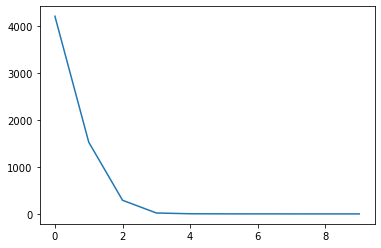

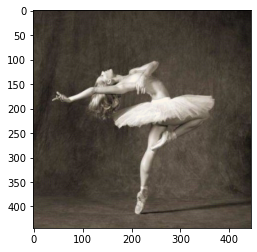

In [209]:
t0 = datetime.now()
losses = []
x = np.random.randn(np.prod(batch_shape))
for i in range(10):
    x, l, _ = fmin_l_bfgs_b(
        func=get_loss_and_grads_wrapper,
        x0=x,
        maxfun=20
    )

    x = np.clip(x, -127, 127)
    print("iter=%s, loss=%s" % (i, l))
    losses.append(l)

print("duration:", datetime.now() - t0)
plt.plot(losses)
plt.show()

newimg = x.reshape(*batch_shape)
final_img = unpreprocess(newimg)

plt.imshow(scale_img(final_img[0]))
plt.show()

In [221]:
from tensorflow import keras

In [228]:
im_size = 128

base_model = keras.applications.vgg16.VGG16(
    weights='imagenet',
    input_shape=(im_size,im_size,3),
    include_top=False
)

In [ ]:
def make_Vgg_Net():
    
    vgg_layers = []
    for layer in base_model.layers:
        if layer.name in ['block1_conv1', 'block2_conv1']:
            layer.trainable = False
            vgg_layers.append(layer.output)
    model = keras.models.Model([base_model.input], [vgg_layers])
    return model

In [ ]:
def make_Vgg_Net():
    
    i = base_model.input
    x = i
    for layer in base_model.layers:
        if layer.name in ['block1_conv1', 'block2_conv1']:
            layer.trainable = False
            vgg_layers.append(layer.output)
    model = keras.models.Model([base_model.input], [vgg_layers])
    return model

In [229]:
vgg = make_Vgg_Net()
vgg.summary()

Model: "model_80"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_58 (InputLayer)       [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
Total params: 112,576
Trainable params: 36,928
Non-trainable params: 75,648
_________________________________________________________________
